# Presentation du notebook

- Ceci est le travail de BENOUAKLIL Hodhaifa et BOUKACEM Younes du groupe SID pour le TP du module "Deep Learning"
- Le notebook présente l'entrainement de 4 modèles (RNN, LSTM, Stacked RNN, CNN + RNN) différents pour la prédiction de la série temporelle relative à la colonne concernée par ce notebook (chaque notebook traite une colonne en particulier)
- Pour chaque modèle, 3 phases sont appliquées:
	- Un modèle de base 'Baseline' est créé, en vu de le comparer avec les 'tuned' modèles par la suite
	- Le modèle est 'tuned' pour trouver les meilleurs valeurs de paramètres possibles (nombre de neurones, longueur de la séquence ...)
	- Le modèle est testé avec différentes longeur de BackTesting (i.e. nombres de points temporels durant lesquels le modèle utilise ses propres prédictions pour en faire de nouvelles) 

# Imports

In [63]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from tqdm import tqdm

In [64]:
column_name = ' SM_50cm'

In [ ]:
# Load the data
file_path = 'DATASET_4_ans.csv'
data = pd.read_csv(file_path)
data.head()

,Year,Month,Day,Hour,Minute,TAir,Precip1,SM_5cm,ST_5cm,SM_10cm,ST_10cm,SM_20cm,ST_20cm,SM_50cm,ST_50cm
0,2014.0,5.0,30.0,12.0,0.0,16.6,0.0,0.188,19.1,0.148,18.8,0.123,18.0,0.165,17.3
1,2014.0,5.0,30.0,13.0,0.0,17.7,0.0,0.187,19.7,0.150,19.5,0.122,18.0,0.164,17.3
2,2014.0,5.0,30.0,14.0,0.0,18.9,0.0,0.187,20.7,0.150,20.3,0.126,18.4,0.165,17.3
3,2014.0,5.0,30.0,15.0,0.0,19.5,0.0,0.186,20.7,0.158,21.1,0.120,18.6,0.167,17.3
4,2014.0,5.0,30.0,16.0,0.0,20.1,0.0,0.183,20.7,0.161,21.1,0.125,19.1,0.167,17.3


In [ ]:
# Get the columns we need for indexing + the target column to predict
data = data[['Year', 'Month', 'Day', 'Hour', 'Minute', column_name]]
# Dropping the null values
data.dropna(axis=0, inplace=True)
# Convert time columns to a datetime index
data['Datetime'] = pd.to_datetime({
    'year': data['Year'].astype(int),
    'month': data['Month'].astype(int),
    'day': data['Day'].astype(int),
    'hour': data['Hour'].astype(int),
    'minute': data['Minute'].astype(int)
})
data.set_index('Datetime', inplace=True)
data = data[[column_name]]
# do resampling so that all entries are equally distant
data = data.resample('h').interpolate()

In [ ]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [68]:
# Create sequences for time series modeling
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24  # e.g., use the past 24 time steps (1 day if hourly data) to predict the next
X, y = create_sequences(data_scaled, sequence_length)

In [69]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

# Simple RNN

## Baseline

In [ ]:
# We create a baseline model to compare to after parameter tuning
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(64, activation='relu', input_shape=(sequence_length, 1),),
    tf.keras.layers.Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_11 (SimpleRNN)       │ (None, 64)             │         4,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,289 (16.75 KB)

 Trainable params: 4,289 (16.75 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Checkpoint callback to save the model
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(f'Baseline_RNN_Simple_{column_name}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0036
Epoch 1: val_loss improved from inf to 0.00023, saving model to Baseline_RNN_Simple_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0036 - val_loss: 2.2787e-04
Epoch 2/20
1129/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9282e-04
Epoch 2: val_loss did not improve from 0.00023
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9291e-04 - val_loss: 3.9133e-04
Epoch 3/20
1117/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.9890e-04
Epoch 3: val_loss did not improve from 0.00023
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9913e-04 - val_loss: 2.9249e-04
Epoch 4/20
1121/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.7738e-04
Epoch 4: val_loss improved from 0.00023 to 0.00019, saving model to Baseline_RNN_Simple_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7777e-04 - val_loss: 1.9300e-04
Epoch 5/20
1122/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.4049e-04
Epoch 5

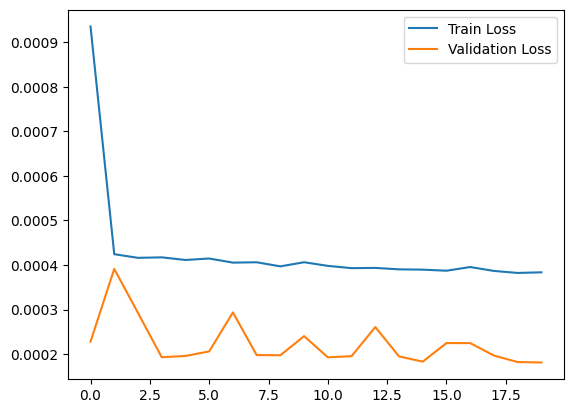

In [73]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [ ]:
# We reload the model (in case we want to change the testing settting without changing the re-training)
model = tf.keras.models.load_model(f'Baseline_RNN_Simple_{column_name}.keras')

In [75]:
# Make predictions
y_pred = model.predict(X_test)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


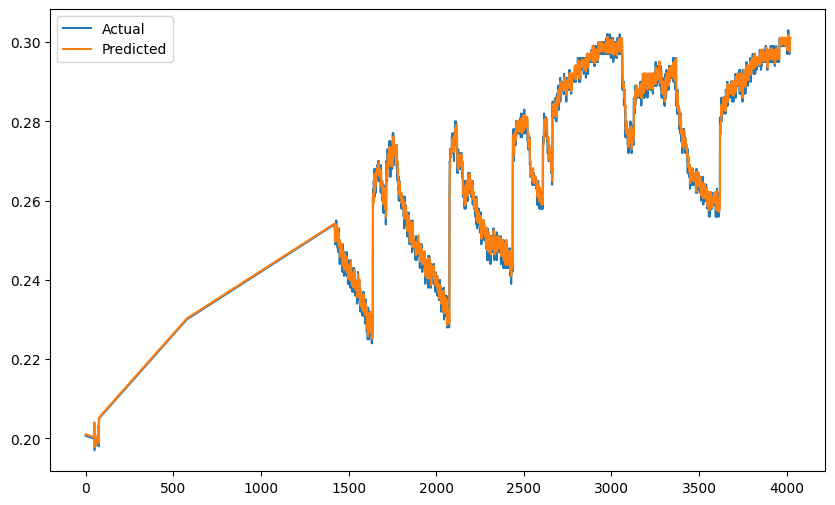

In [76]:
# Rescale predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

In [ ]:
# We compute the mse
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4.352175707021953e-06


## Parameter-Tuning

In [78]:
# tune the sequence length and the number of neurons in the RNN layer
sequence_lengths = [12, 24, 48]
neurons = [32, 64, 128]

best_mse = float('inf')

for sequence_length in sequence_lengths:
    X, y = create_sequences(data_scaled, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    for neuron in neurons:
        model = tf.keras.Sequential([
            tf.keras.layers.SimpleRNN(neuron, activation='relu', input_shape=(sequence_length, 1)),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        print(f'==================================================================================================')
        print(f'Training model with sequence length {sequence_length} and {neuron} neurons')
        print(f'==================================================================================================')
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
        y_pred = model.predict(X_val)
        y_val_rescaled = scaler.inverse_transform(y_val)
        y_pred_rescaled = scaler.inverse_transform(y_pred)
        mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
        if mse < best_mse:
            best_mse = mse
            best_sequence_length = sequence_length
            best_neuron = neuron
            print(f'New best MSE: {best_mse} with sequence_length = {best_sequence_length} and neuron = {best_neuron}')

print(f'==================================================================================================')
print(f'==================================================================================================')
print(f'Best MSE: {best_mse} with sequence_length = {best_sequence_length} and neuron = {best_neuron}')

Training model with sequence length 12 and 32 neurons
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0067 - val_loss: 3.4163e-04
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.8328e-04 - val_loss: 2.9554e-04
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7907e-04 - val_loss: 4.7510e-04
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3761e-04 - val_loss: 3.0032e-04
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1858e-04 - val_loss: 3.1670e-04
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4699e-04 - val_loss: 3.1461e-04
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8335e-04 - val_loss: 4.1107e-04
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1682e-04 - val_loss: 3.1183e-04
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.5959e-04 - val_loss: 4.5333e-04
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9534e-04 - val_loss: 3.2811e-04
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0125 - val_loss: 5.0677e-04
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.3931e-04 - val_loss: 5.1148e-04
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.4151e-04 - val_loss: 3.8251e-04
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6443e-04 - val_loss: 3.1137e-04
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9430e-04 - val_loss: 3.9418e-04
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1898e-04 - val_loss: 3.1957e-04
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7184e-04 - val_loss: 3.6969e-04
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1951e-04 - val_loss: 3.2928e-04
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5124e-04 - val_loss: 3.0513e-04
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5617e-04 - val_loss: 3.0857e-04
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0167 - val_loss: 2.9574e-04
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6707e-04 - val_loss: 3.4062e-04
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7103e-04 - val_loss: 3.1397e-04
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3752e-04 - val_loss: 3.9386e-04
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7250e-04 - val_loss: 3.3715e-04
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0243e-04 - val_loss: 3.2436e-04
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9192e-04 - val_loss: 4.2435e-04
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.1766e-04 - val_loss: 3.2652e-04
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0979e-04 - val_loss: 3.2352e-04
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3846e-04 - val_loss: 5.0783e-04
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0356 - val_loss: 3.6351e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 6.1687e-04 - val_loss: 5.6471e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1431e-04 - val_loss: 5.2757e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1546e-04 - val_loss: 3.3493e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.5791e-04 - val_loss: 4.9755e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1230e-04 - val_loss: 3.4724e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7763e-04 - val_loss: 4.1745e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3573e-04 - val_loss: 3.3054e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5349e-04 - val_loss: 3.1696e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4724e-04 - val_loss: 4.5422e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0105 - val_loss: 3.7796e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.2363e-04 - val_loss: 4.7397e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1910e-04 - val_loss: 4.3161e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3520e-04 - val_loss: 4.8356e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8317e-04 - val_loss: 3.0887e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7335e-04 - val_loss: 3.6799e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7534e-04 - val_loss: 3.7440e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3027e-04 - val_loss: 3.5243e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9694e-04 - val_loss: 3.3064e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1614e-04 - val_loss: 3.2053e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0085 - val_loss: 3.0340e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7397e-04 - val_loss: 3.2458e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.2923e-04 - val_loss: 3.2193e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7216e-04 - val_loss: 3.1437e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6022e-04 - val_loss: 3.6096e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1192e-04 - val_loss: 4.0729e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1867e-04 - val_loss: 3.2470e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6550e-04 - val_loss: 3.6131e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0623e-04 - val_loss: 4.7240e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9661e-04 - val_loss: 3.4488e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0216 - val_loss: 3.0613e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.9307e-04 - val_loss: 3.8249e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.2306e-04 - val_loss: 3.2473e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.8622e-04 - val_loss: 3.4517e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.8112e-04 - val_loss: 3.0996e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.4229e-04 - val_loss: 3.1296e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9373e-04 - val_loss: 3.5150e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.8369e-04 - val_loss: 3.1792e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.0730e-04 - val_loss: 3.6450e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.1959e-04 - val_loss: 4.2634e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0127 - val_loss: 3.2927e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.7978e-04 - val_loss: 3.1573e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.0746e-04 - val_loss: 3.4370e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9470e-04 - val_loss: 4.0256e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.5763e-04 - val_loss: 3.5020e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9082e-04 - val_loss: 4.7479e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.1230e-04 - val_loss: 3.2502e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.6206e-04 - val_loss: 3.4787e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.5499e-04 - val_loss: 4.1449e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.3173e-04 - val_loss: 3.2166e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0120 - val_loss: 3.0724e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.4696e-04 - val_loss: 3.1023e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 5.0700e-04 - val_loss: 5.5821e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.0013e-04 - val_loss: 3.5684e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.2873e-04 - val_loss: 3.4229e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.3131e-04 - val_loss: 3.9613e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.8015e-04 - val_loss: 6.7939e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9015e-04 - val_loss: 3.4722e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.2684e-04 - val_loss: 3.7739e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.6512e-04 - val_loss: 3.8040e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

In [79]:
# Retrain the model using the best parameters on the whole train data and save it
X, y = create_sequences(data_scaled, best_sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
model = tf.keras.Sequential([
			tf.keras.layers.SimpleRNN(best_neuron, activation='relu', input_shape=(best_sequence_length, 1)),
			tf.keras.layers.Dense(1)
		])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
model.save(f"Best_RNN_Simple_{column_name}.keras")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1132/1132 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0293 - val_loss: 3.7346e-04
Epoch 2/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2055e-04 - val_loss: 3.6060e-04
Epoch 3/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7770e-04 - val_loss: 3.1391e-04
Epoch 4/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6976e-04 - val_loss: 3.0633e-04
Epoch 5/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2761e-04 - val_loss: 3.4583e-04
Epoch 6/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9897e-04 - val_loss: 3.1105e-04
Epoch 7/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.0038e-04 - val_loss: 3.6167e-04
Epoch 8/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9317e-04 - val_loss: 4.5390e-04
Epoch 9/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.8233e-04 - val_loss: 5.7533e-04
Epoch 10/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9900e-04 - val_loss: 3.2100e-04
Epoch 11/20
1132/1132 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error: 4.7885450234938765e-06


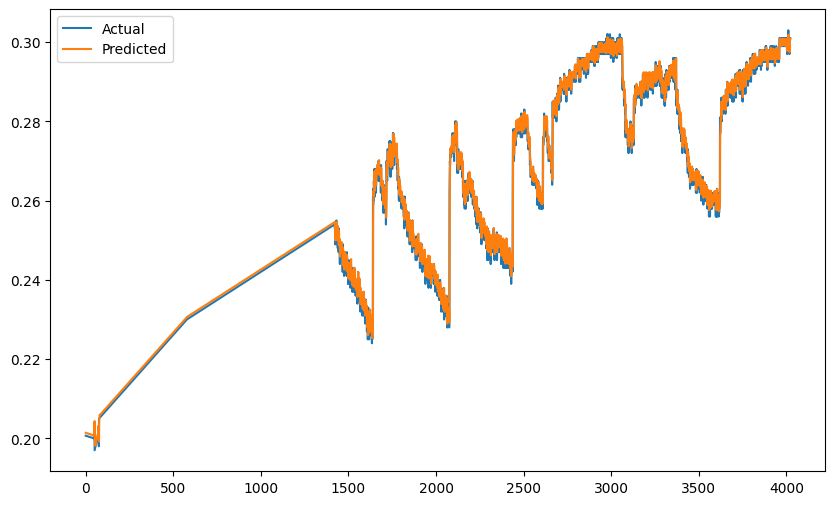

In [80]:
# Test the model and print the curves
model = tf.keras.models.load_model(f'Best_RNN_Simple_{column_name}.keras')
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

## Backtesting

In [ ]:
# Computing the predictions for different backtesting windows (the number of datapoints for which the model relies on its own predictions to make future predictions)
backtesting_windows = [5, 10, 20]
y_preds = {}
model = tf.keras.models.load_model(f'Best_RNN_Simple_{column_name}.keras')
for backtesting_window in backtesting_windows:
	print("==========================================")
	print(f"Backtesting window = {backtesting_window}")
	print("==========================================")
	y_preds[backtesting_window] = []
	for i in tqdm(range(0, len(X_test), backtesting_window)):
		lags = np.array(X_test[i])
		for _ in range(backtesting_window):
			new_value = model.predict(np.expand_dims(lags, 0), verbose=0)
			y_preds[backtesting_window].append(new_value)
			lags = np.concatenate((lags[1:], new_value))

Backtesting window = 5


100%|██████████| 805/805 [03:35<00:00,  3.73it/s]


Backtesting window = 10


100%|██████████| 403/403 [03:33<00:00,  1.88it/s]


Backtesting window = 20


100%|██████████| 202/202 [03:27<00:00,  1.03s/it]


btw = 5, mse = 9.534529844045587e-06
btw = 10, mse = 1.7415717855935297e-05
btw = 20, mse = 4.190723890105522e-05
avg = 2.29524955336787e-05


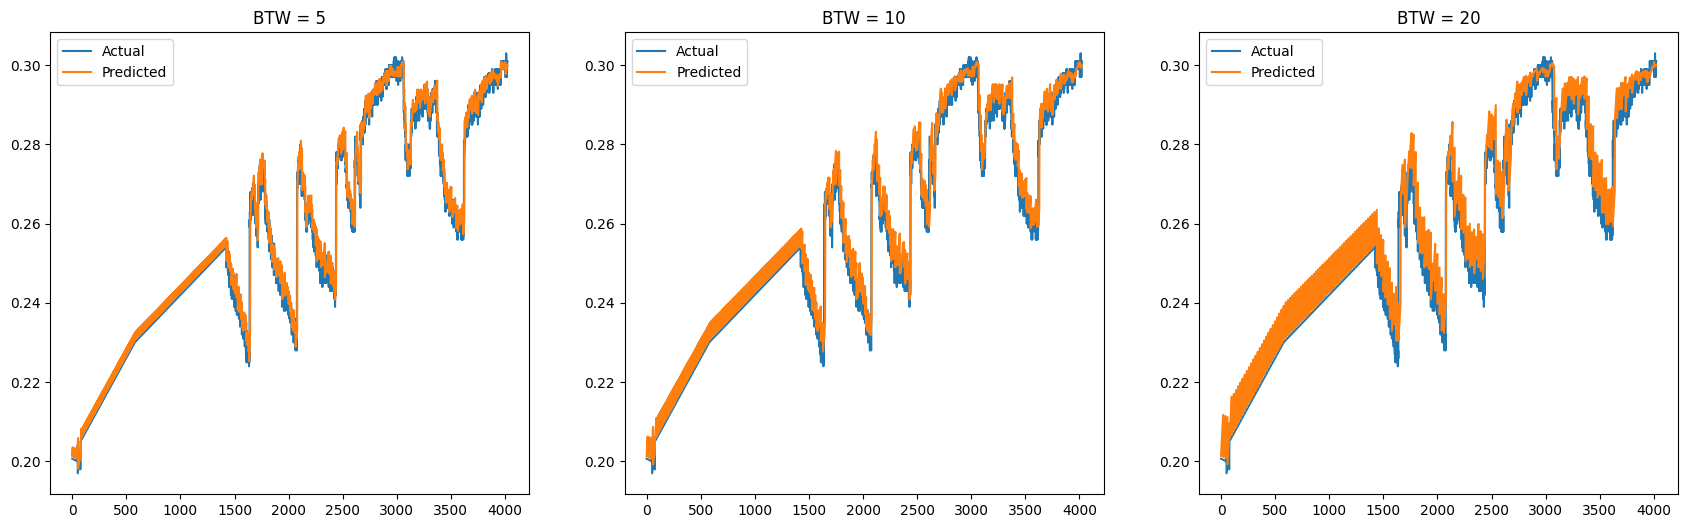

In [82]:
# Computing the errors and plotting the graphs
avg = 0
fig, axs = plt.subplots(1, 3, figsize=(21,6))
for i, (btw, y_pred) in enumerate(y_preds.items()):
	y_pred_rescaled = scaler.inverse_transform(np.array(y_pred)[:,:,0][:len(y_test)])
	y_test_rescaled = scaler.inverse_transform(y_test)
	axs[i].plot(y_test_rescaled, label = 'Actual')
	axs[i].plot(y_pred_rescaled, label = 'Predicted')
	axs[i].set_title(f"BTW = {btw}")
	axs[i].legend()
	mse = mean_squared_error(y_pred_rescaled, y_test_rescaled)
	avg += mse
	print(f"btw = {btw}, mse = {mse}")
print(f"avg = {avg/3}")
plt.show()

# LSTM

In [ ]:
# Load the data
file_path = 'DATASET_4_ans.csv'
data = pd.read_csv(file_path)
# Load the data
data.head()

,Year,Month,Day,Hour,Minute,TAir,Precip1,SM_5cm,ST_5cm,SM_10cm,ST_10cm,SM_20cm,ST_20cm,SM_50cm,ST_50cm
0,2014.0,5.0,30.0,12.0,0.0,16.6,0.0,0.188,19.1,0.148,18.8,0.123,18.0,0.165,17.3
1,2014.0,5.0,30.0,13.0,0.0,17.7,0.0,0.187,19.7,0.150,19.5,0.122,18.0,0.164,17.3
2,2014.0,5.0,30.0,14.0,0.0,18.9,0.0,0.187,20.7,0.150,20.3,0.126,18.4,0.165,17.3
3,2014.0,5.0,30.0,15.0,0.0,19.5,0.0,0.186,20.7,0.158,21.1,0.120,18.6,0.167,17.3
4,2014.0,5.0,30.0,16.0,0.0,20.1,0.0,0.183,20.7,0.161,21.1,0.125,19.1,0.167,17.3


In [84]:
data = data[['Year', 'Month', 'Day', 'Hour', 'Minute', column_name]]
data.dropna(axis=0, inplace=True)
# Convert time columns to a datetime index
data['Datetime'] = pd.to_datetime({
    'year': data['Year'].astype(int),
    'month': data['Month'].astype(int),
    'day': data['Day'].astype(int),
    'hour': data['Hour'].astype(int),
    'minute': data['Minute'].astype(int)
})
data.set_index('Datetime', inplace=True)
data = data[[column_name]]
data = data.resample('h').interpolate()

In [85]:
# # Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [86]:
# Create sequences for time series modeling
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24  # e.g., use the past 24 time steps (1 day if hourly data) to predict the next
X, y = create_sequences(data_scaled, sequence_length)

In [87]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Baseline

In [88]:
# Build the RNN model (LSTM example)
model = tf.keras.Sequential([
    tf.keras.layers.LSTM(64, activation='relu', input_shape=(sequence_length, 1),),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,961 (66.25 KB)

 Trainable params: 16,961 (66.25 KB)

 Non-trainable params: 0 (0.00 B)

In [89]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(f'Baseline_LSTM_Simple_{column_name}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0195
Epoch 1: val_loss improved from inf to 0.00030, saving model to Baseline_LSTM_Simple_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0195 - val_loss: 3.0355e-04
Epoch 2/20
1122/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 6.4226e-04
Epoch 2: val_loss improved from 0.00030 to 0.00020, saving model to Baseline_LSTM_Simple_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 6.4191e-04 - val_loss: 2.0491e-04
Epoch 3/20
1128/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.6990e-04
Epoch 3: val_loss did not improve from 0.00020
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.6970e-04 - val_loss: 2.9871e-04
Epoch 4/20
1115/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.6996e-04
Epoch 4: val_loss improved from 0.00020 to 0.00019, saving model to Baseline_LSTM_Simple_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6994e-04 - val_loss: 1.8525e-04
Epoch 5/20
1125/1131 

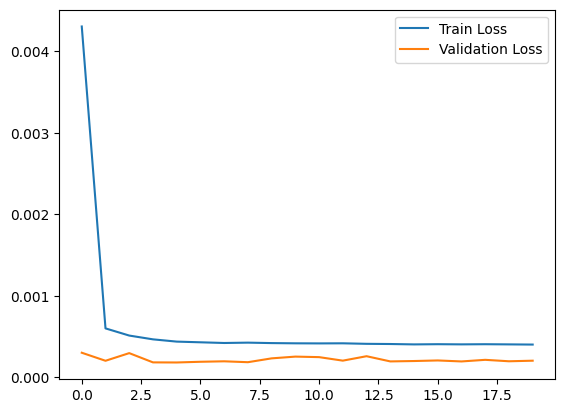

In [91]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [92]:
model = tf.keras.models.load_model(f'Baseline_LSTM_Simple_{column_name}.keras')

In [93]:
# Make predictions
y_pred = model.predict(X_test)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


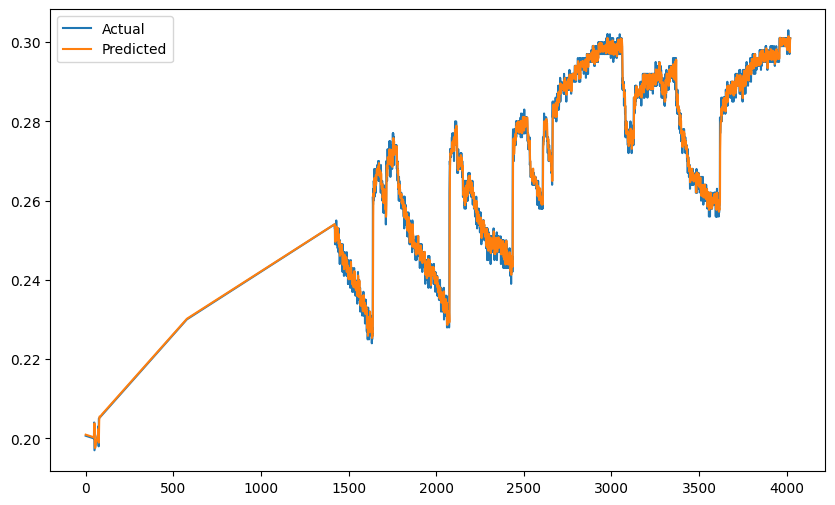

In [94]:
# Rescale predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

In [95]:
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4.42059894393161e-06


## Parameter-Tuning

In [96]:
# tune the sequence length and the number of neurons in the RNN layer
sequence_lengths = [12, 24, 48]
neurons = [32, 64, 128]

best_mse = float('inf')

for sequence_length in sequence_lengths:
    X, y = create_sequences(data_scaled, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    for neuron in neurons:
        model = tf.keras.Sequential([
            tf.keras.layers.LSTM(neuron, activation='relu', input_shape=(sequence_length, 1)),
            tf.keras.layers.Dense(1)
        ])
        model.compile(optimizer='adam', loss='mse')
        print(f'==================================================================================================')
        print(f'Training model with sequence length {sequence_length} and {neuron} neurons')
        print(f'==================================================================================================')
        history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
        y_pred = model.predict(X_val)
        y_pred_rescaled = scaler.inverse_transform(y_pred)
        y_val_rescaled = scaler.inverse_transform(y_val)
        mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
        if mse < best_mse:
            best_mse = mse
            best_sequence_length = sequence_length
            best_neuron = neuron
            print(f'New best MSE: {best_mse} with sequence_length = {best_sequence_length} and neuron = {best_neuron}')

print(f'==================================================================================================')
print(f'==================================================================================================')
print(f'Best MSE: {best_mse} with sequence_length = {best_sequence_length} and neuron = {best_neuron}')

Training model with sequence length 12 and 32 neurons
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0149 - val_loss: 3.1038e-04
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.9293e-04 - val_loss: 3.7037e-04
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 5.4742e-04 - val_loss: 3.1563e-04
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.7433e-04 - val_loss: 3.5375e-04
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6943e-04 - val_loss: 3.0884e-04
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5258e-04 - val_loss: 4.2732e-04
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3277e-04 - val_loss: 2.9813e-04
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.9130e-04 - val_loss: 3.1482e-04
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.2563e-04 - val_loss: 2.9812e-04
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6938e-04 - val_loss: 3.3673e-04
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 0.0261 - val_loss: 4.3799e-04
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.4026e-04 - val_loss: 2.9163e-04
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9050e-04 - val_loss: 2.9172e-04
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.9769e-04 - val_loss: 6.8313e-04
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.6977e-04 - val_loss: 4.0347e-04
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1851e-04 - val_loss: 3.7612e-04
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1447e-04 - val_loss: 4.1860e-04
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1287e-04 - val_loss: 3.0986e-04
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1952e-04 - val_loss: 5.0797e-04
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.0115e-04 - val_loss: 3.6877e-04
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1019/1019 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0158 - val_loss: 6.3200e-04
Epoch 2/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.7745e-04 - val_loss: 2.8509e-04
Epoch 3/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 6.1501e-04 - val_loss: 2.8992e-04
Epoch 4/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.3800e-04 - val_loss: 3.5901e-04
Epoch 5/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.1384e-04 - val_loss: 3.9601e-04
Epoch 6/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8718e-04 - val_loss: 5.4410e-04
Epoch 7/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.5096e-04 - val_loss: 3.0989e-04
Epoch 8/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 4.8537e-04 - val_loss: 3.3663e-04
Epoch 9/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 4.5629e-04 - val_loss: 5.0224e-04
Epoch 10/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 3.7787e-04 - val_loss: 3.3340e-04
Epoch 11/20
1019/1019 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0561 - val_loss: 3.3192e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 8.3371e-04 - val_loss: 2.9523e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.5776e-04 - val_loss: 3.0247e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1347e-04 - val_loss: 3.9792e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5600e-04 - val_loss: 3.1449e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5229e-04 - val_loss: 3.8216e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5060e-04 - val_loss: 5.9981e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0330e-04 - val_loss: 3.3584e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3465e-04 - val_loss: 3.5762e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1585e-04 - val_loss: 3.1156e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0178 - val_loss: 0.0013
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.6080e-04 - val_loss: 3.0987e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.8089e-04 - val_loss: 3.3211e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3499e-04 - val_loss: 2.9827e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0494e-04 - val_loss: 3.1512e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9798e-04 - val_loss: 3.0108e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5116e-04 - val_loss: 3.5455e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3168e-04 - val_loss: 3.2506e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0093e-04 - val_loss: 3.1557e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4125e-04 - val_loss: 6.1192e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - l

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 0.0131 - val_loss: 3.0374e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.5755e-04 - val_loss: 2.9394e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.0864e-04 - val_loss: 3.7473e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6099e-04 - val_loss: 3.8910e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1409e-04 - val_loss: 3.1851e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1705e-04 - val_loss: 4.2973e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.7060e-04 - val_loss: 3.0990e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.6964e-04 - val_loss: 3.1611e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.8728e-04 - val_loss: 4.7845e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.1441e-04 - val_loss: 3.1150e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0168 - val_loss: 4.0064e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.6404e-04 - val_loss: 3.6676e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.4647e-04 - val_loss: 3.3838e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.2459e-04 - val_loss: 2.8339e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.4960e-04 - val_loss: 2.8992e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.4405e-04 - val_loss: 2.9359e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.7863e-04 - val_loss: 4.9645e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1167e-04 - val_loss: 3.1144e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.7684e-04 - val_loss: 2.9989e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.8668e-04 - val_loss: 3.0195e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0282 - val_loss: 5.8864e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 7.1491e-04 - val_loss: 2.9107e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.3592e-04 - val_loss: 2.9110e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 5.4173e-04 - val_loss: 3.2048e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.9108e-04 - val_loss: 3.2524e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.8752e-04 - val_loss: 3.4550e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.2197e-04 - val_loss: 3.0147e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.5146e-04 - val_loss: 4.2586e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.4159e-04 - val_loss: 3.1233e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.3130e-04 - val_loss: 3.1304e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0142 - val_loss: 3.3013e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 5.9732e-04 - val_loss: 3.0449e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 5.1295e-04 - val_loss: 3.9096e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.9078e-04 - val_loss: 3.1183e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.0574e-04 - val_loss: 4.6555e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.4533e-04 - val_loss: 5.5727e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.8353e-04 - val_loss: 3.8050e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.4529e-04 - val_loss: 5.3115e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 4.8011e-04 - val_loss: 3.5376e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 3.7778e-04 - val_loss: 4.3063e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

In [97]:
# Train a model with the best parameters
X, y = create_sequences(data_scaled, best_sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
model = tf.keras.Sequential([
			tf.keras.layers.LSTM(best_neuron, activation='relu', input_shape=(best_sequence_length, 1)),
			tf.keras.layers.Dense(1)
		])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
model.save(f"Best_LSTM_Simple_{column_name}.keras")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0161 - val_loss: 606281.0625
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.9066e-04 - val_loss: 10.3771
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.3786e-04 - val_loss: 11.8387
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3455e-04 - val_loss: 0.0012
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3883e-04 - val_loss: 0.0021
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8396e-04 - val_loss: 8.4204e-04
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.0091e-04 - val_loss: 3.4174e-04
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.7892e-04 - val_loss: 3.0791e-04
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8312e-04 - val_loss: 6.2720e-04
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.6770e-04 - val_loss: 3.0543e-04
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.29

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error: 4.677794844756421e-06


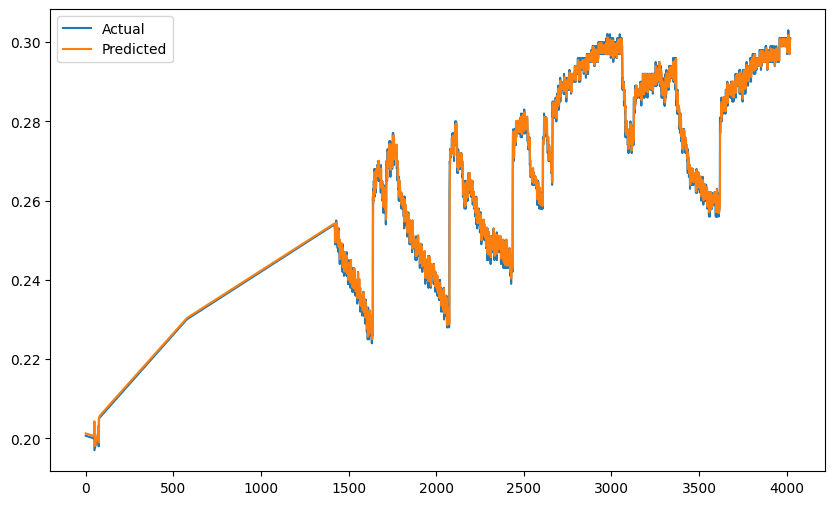

In [98]:
# Test the model and print the curves
model = tf.keras.models.load_model(f'Best_LSTM_Simple_{column_name}.keras')
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

## Backtesting

In [99]:
# Computing the predictions for different backtesting windows
backtesting_windows = [5, 10, 20]
y_preds = {}
model = tf.keras.models.load_model(f'Best_LSTM_Simple_{column_name}.keras')
for backtesting_window in backtesting_windows:
	print("==========================================")
	print(f"Backtesting window = {backtesting_window}")
	print("==========================================")
	y_preds[backtesting_window] = []
	for i in tqdm(range(0, len(X_test), backtesting_window)):
		lags = np.array(X_test[i])
		for _ in range(backtesting_window):
			new_value = model.predict(np.expand_dims(lags, 0), verbose=0)
			y_preds[backtesting_window].append(new_value)
			lags = np.concatenate((lags[1:], new_value))

Backtesting window = 5


100%|██████████| 805/805 [03:16<00:00,  4.10it/s]


Backtesting window = 10


100%|██████████| 403/403 [03:15<00:00,  2.06it/s]


Backtesting window = 20


100%|██████████| 202/202 [03:16<00:00,  1.03it/s]


btw = 5, mse = 7.843776208173384e-06
btw = 10, mse = 1.0723974384813199e-05
btw = 20, mse = 1.959394455592014e-05
avg = 1.2720565049635574e-05


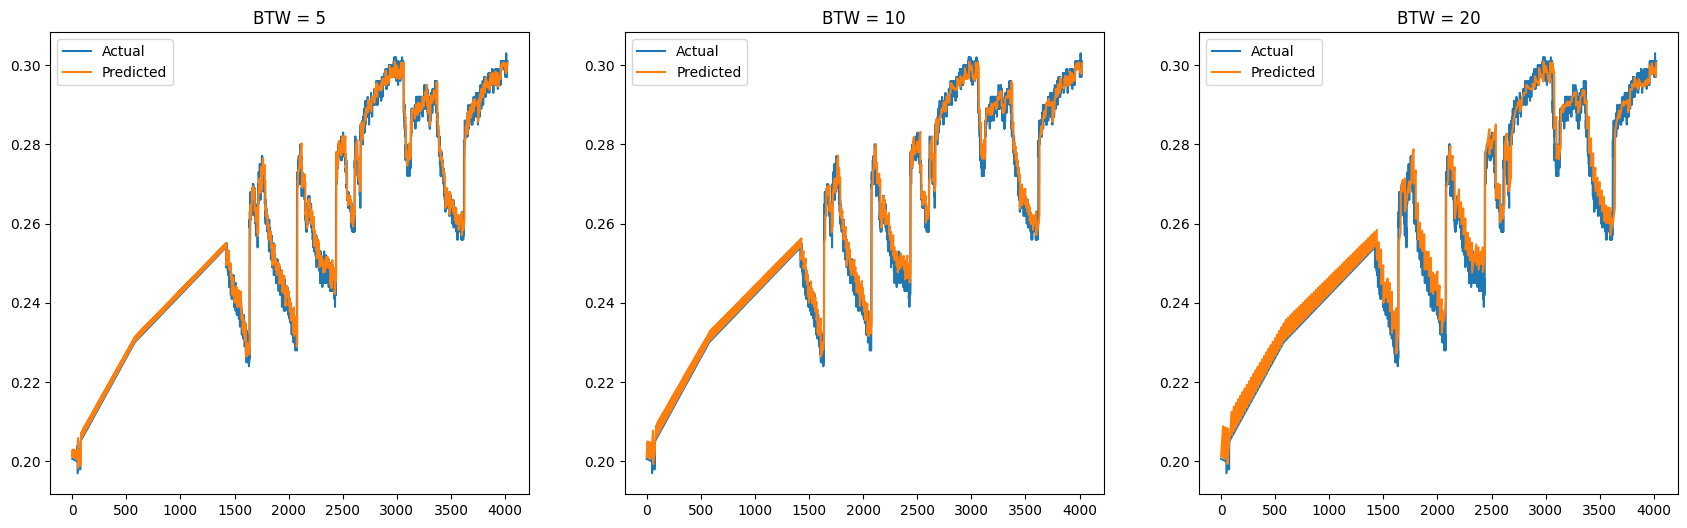

In [100]:
# Computing the errors and plotting the graphs
avg = 0
fig, axs = plt.subplots(1, 3, figsize=(21,6))
for i, (btw, y_pred) in enumerate(y_preds.items()):
	y_pred_rescaled = scaler.inverse_transform(np.array(y_pred)[:,:,0][:len(y_test)])
	y_test_rescaled = scaler.inverse_transform(y_test)
	axs[i].plot(y_test_rescaled, label = 'Actual')
	axs[i].plot(y_pred_rescaled, label = 'Predicted')
	axs[i].set_title(f"BTW = {btw}")
	axs[i].legend()
	mse = mean_squared_error(y_pred_rescaled, y_test_rescaled)
	avg += mse
	print(f"btw = {btw}, mse = {mse}")
print(f"avg = {avg/3}")
plt.show()

# Stacked RNN

In [ ]:
# Load the data
file_path = 'DATASET_4_ans.csv'
data = pd.read_csv(file_path)
data.head()

,Year,Month,Day,Hour,Minute,TAir,Precip1,SM_5cm,ST_5cm,SM_10cm,ST_10cm,SM_20cm,ST_20cm,SM_50cm,ST_50cm
0,2014.0,5.0,30.0,12.0,0.0,16.6,0.0,0.188,19.1,0.148,18.8,0.123,18.0,0.165,17.3
1,2014.0,5.0,30.0,13.0,0.0,17.7,0.0,0.187,19.7,0.150,19.5,0.122,18.0,0.164,17.3
2,2014.0,5.0,30.0,14.0,0.0,18.9,0.0,0.187,20.7,0.150,20.3,0.126,18.4,0.165,17.3
3,2014.0,5.0,30.0,15.0,0.0,19.5,0.0,0.186,20.7,0.158,21.1,0.120,18.6,0.167,17.3
4,2014.0,5.0,30.0,16.0,0.0,20.1,0.0,0.183,20.7,0.161,21.1,0.125,19.1,0.167,17.3


In [102]:
data = data[['Year', 'Month', 'Day', 'Hour', 'Minute', column_name]]
data.dropna(axis=0, inplace=True)
# Convert time columns to a datetime index
data['Datetime'] = pd.to_datetime({
    'year': data['Year'].astype(int),
    'month': data['Month'].astype(int),
    'day': data['Day'].astype(int),
    'hour': data['Hour'].astype(int),
    'minute': data['Minute'].astype(int)
})
data.set_index('Datetime', inplace=True)
data = data[[column_name]]
data = data.resample('h').interpolate()

In [103]:
# # Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [104]:
# Create sequences for time series modeling
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24  # e.g., use the past 24 time steps (1 day if hourly data) to predict the next
X, y = create_sequences(data_scaled, sequence_length)

In [105]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Baseline

In [106]:
# Build the RNN model (LSTM example)
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(128, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
    tf.keras.layers.SimpleRNN(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_33"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_22 (SimpleRNN)       │ (None, 24, 128)        │        16,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_23 (SimpleRNN)       │ (None, 64)             │        12,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,057 (113.50 KB)

 Trainable params: 29,057 (113.50 KB)

 Non-trainable params: 0 (0.00 B)

In [107]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(f'Baseline_RNN_Stacked_{column_name}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0097
Epoch 1: val_loss improved from inf to 0.00022, saving model to Baseline_RNN_Stacked_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0097 - val_loss: 2.2142e-04
Epoch 2/20
1128/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.2793e-04
Epoch 2: val_loss improved from 0.00022 to 0.00018, saving model to Baseline_RNN_Stacked_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.2798e-04 - val_loss: 1.7753e-04
Epoch 3/20
1122/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5877e-04
Epoch 3: val_loss did not improve from 0.00018
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.5843e-04 - val_loss: 2.0444e-04
Epoch 4/20
1121/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.1230e-04
Epoch 4: val_loss did not improve from 0.00018
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1246e-04 - val_loss: 2.3901e-04
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 4.8005e-04
Epoch

In [109]:
# Saving the model
model = tf.keras.models.load_model(f'Baseline_RNN_Stacked_{column_name}.keras')

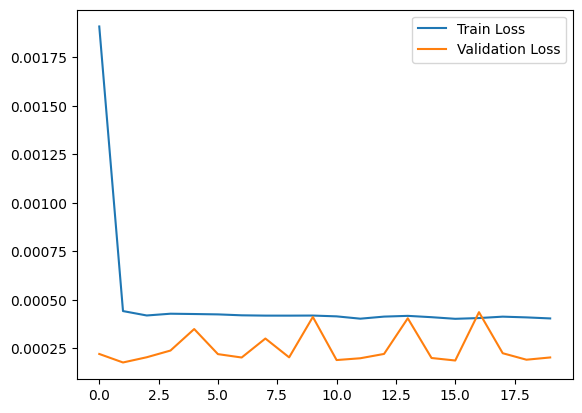

In [110]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
mse = 4.2652738598514746e-06


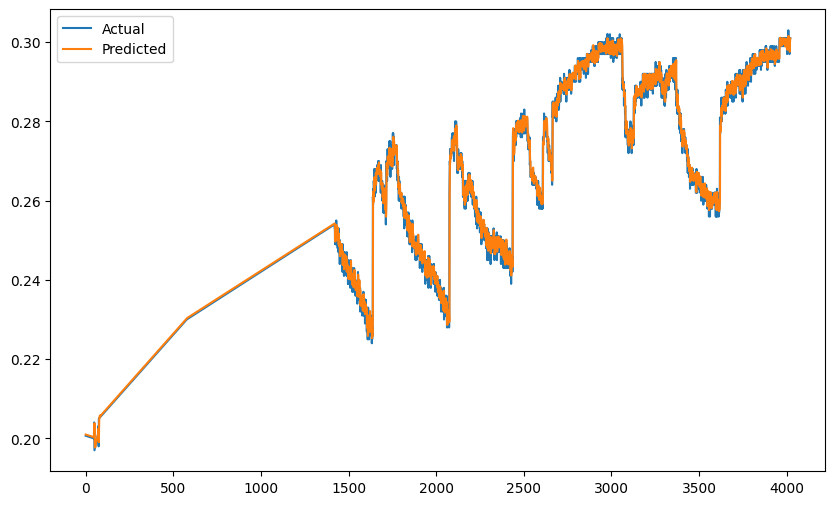

In [111]:
# Make predictions
y_pred = model.predict(X_test)
# Rescale predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
# Compute the mse
print(f"mse = {mean_squared_error(y_pred_rescaled, y_test_rescaled)}")
# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

## Parameter-Tuning

In [112]:
# tune the sequence length and the number of neurons in the RNN layer
sequence_lengths = [24, 48]
neurons1 = [32, 64]
neurons2 = [32, 64]

best_mse = float('inf')

for sequence_length in sequence_lengths:
    X, y = create_sequences(data_scaled, sequence_length)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
    for neuron1 in neurons1:
        for neuron2 in neurons2:
            model = tf.keras.Sequential([
                tf.keras.layers.SimpleRNN(neuron1, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
                tf.keras.layers.SimpleRNN(neuron2, activation='relu'),
                tf.keras.layers.Dense(1)
            ])
            model.compile(optimizer='adam', loss='mse')
            print(f'==================================================================================================')
            print(f'Training model with sequence length {sequence_length} and {neuron1} neuron1 and {neuron2} neuron2')
            print(f'==================================================================================================')
            history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
            y_pred = model.predict(X_val)
            y_val_rescaled = scaler.inverse_transform(y_val)
            y_pred_rescaled = scaler.inverse_transform(y_pred)
            mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
            if mse < best_mse:
                best_mse = mse
                best_sequence_length = sequence_length
                best_neuron1 = neuron1
                best_neuron2 = neuron2
                print(f'New best MSE: {best_mse} with sequence length {best_sequence_length} and {best_neuron1} neurons 1 and {best_neuron2} neurons 2')

print(f'==================================================================================================')
print(f'==================================================================================================')
print(f'Best MSE: {best_mse} with sequence length {best_sequence_length} and {best_neuron1} neurons 1 and {best_neuron2} neurons 2')

Training model with sequence length 24 and 32 neuron1 and 32 neuron2
Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0213 - val_loss: 3.0632e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.1273e-04 - val_loss: 3.1427e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.0273e-04 - val_loss: 3.1506e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.2669e-04 - val_loss: 3.0822e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.3301e-04 - val_loss: 3.0538e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.6999e-04 - val_loss: 5.3213e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.4942e-04 - val_loss: 3.7931e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.6959e-04 - val_loss: 2.8337e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9634e-04 - val_loss: 2.8186e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.5825e-04 - val_loss: 2.7564e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0029 - val_loss: 2.9398e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.7349e-04 - val_loss: 2.8976e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.8045e-04 - val_loss: 3.0332e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.6719e-04 - val_loss: 3.0193e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.8307e-04 - val_loss: 3.5227e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.1620e-04 - val_loss: 2.9315e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.9605e-04 - val_loss: 2.8447e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 4.2039e-04 - val_loss: 2.8209e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.8116e-04 - val_loss: 2.7795e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.6736e-04 - val_loss: 3.4216e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 0.0295 - val_loss: 4.4134e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.7952e-04 - val_loss: 3.5376e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.9231e-04 - val_loss: 4.0874e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.5591e-04 - val_loss: 2.9332e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.2779e-04 - val_loss: 4.9395e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.0958e-04 - val_loss: 3.2544e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.2778e-04 - val_loss: 4.1804e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 3.9326e-04 - val_loss: 4.2972e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 4.1683e-04 - val_loss: 4.5423e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.2276e-04 - val_loss: 3.4996e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0099 - val_loss: 6.6302e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1683e-04 - val_loss: 3.2147e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1947e-04 - val_loss: 5.8394e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1621e-04 - val_loss: 4.0974e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1698e-04 - val_loss: 2.9710e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.7828e-04 - val_loss: 2.9961e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.0092e-04 - val_loss: 2.9633e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.0181e-04 - val_loss: 5.2330e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.8523e-04 - val_loss: 3.2155e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 3.8965e-04 - val_loss: 2.9312e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - loss: 0.0156 - val_loss: 3.1362e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.4574e-04 - val_loss: 3.0032e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.0712e-04 - val_loss: 3.4433e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.4003e-04 - val_loss: 3.7825e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.1634e-04 - val_loss: 3.7322e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.6381e-04 - val_loss: 2.8841e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.3682e-04 - val_loss: 3.1160e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.5384e-04 - val_loss: 2.9119e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.9846e-04 - val_loss: 3.5111e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.7744e-04 - val_loss: 3.5312e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0063 - val_loss: 3.3082e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.0960e-04 - val_loss: 8.3804e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.8813e-04 - val_loss: 3.0413e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.9561e-04 - val_loss: 3.3749e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.1236e-04 - val_loss: 3.0305e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.5047e-04 - val_loss: 2.7969e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.4880e-04 - val_loss: 2.8544e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.7610e-04 - val_loss: 4.0833e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 3.7669e-04 - val_loss: 3.0294e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 4.4985e-04 - val_loss: 5.5404e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 0.0045 - val_loss: 3.0255e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.8975e-04 - val_loss: 2.9067e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.9511e-04 - val_loss: 2.9253e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.1431e-04 - val_loss: 4.8276e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.0821e-04 - val_loss: 2.9031e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.3651e-04 - val_loss: 3.2033e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.1282e-04 - val_loss: 5.7207e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.2055e-04 - val_loss: 4.0058e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.6251e-04 - val_loss: 3.6399e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.7008e-04 - val_loss: 3.1831e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/ste

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 11s 9ms/step - loss: 0.0066 - val_loss: 2.9374e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.9412e-04 - val_loss: 3.1713e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.3952e-04 - val_loss: 3.1918e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.9614e-04 - val_loss: 3.6361e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.4573e-04 - val_loss: 3.4378e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.7996e-04 - val_loss: 5.5531e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.7828e-04 - val_loss: 3.3457e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.7503e-04 - val_loss: 3.0961e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 4.5262e-04 - val_loss: 3.6824e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/step - loss: 3.7171e-04 - val_loss: 2.8414e-04
Epoch 11/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 8s 8ms/ste

In [113]:
# Train a model with the best parameters
X, y = create_sequences(data_scaled, best_sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
model = tf.keras.Sequential([
	tf.keras.layers.SimpleRNN(best_neuron1, activation='relu', input_shape=(sequence_length, 1), return_sequences=True),
	tf.keras.layers.SimpleRNN(best_neuron2, activation='relu'),
	tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
model.save(f"Best_RNN_Stacked_{column_name}.keras")

Epoch 1/20


/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1131/1131 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - loss: 0.0044 - val_loss: 3.3615e-04
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.5678e-04 - val_loss: 3.3400e-04
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.1972e-04 - val_loss: 2.9825e-04
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.8548e-04 - val_loss: 3.2532e-04
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.9928e-04 - val_loss: 3.0505e-04
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.6770e-04 - val_loss: 3.7787e-04
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.1928e-04 - val_loss: 2.9555e-04
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.7895e-04 - val_loss: 3.6053e-04
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 3.8096e-04 - val_loss: 3.2127e-04
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 4.1962e-04 - val_loss: 3.5967e-04
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/ste

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Mean Squared Error: 5.168559934334051e-06


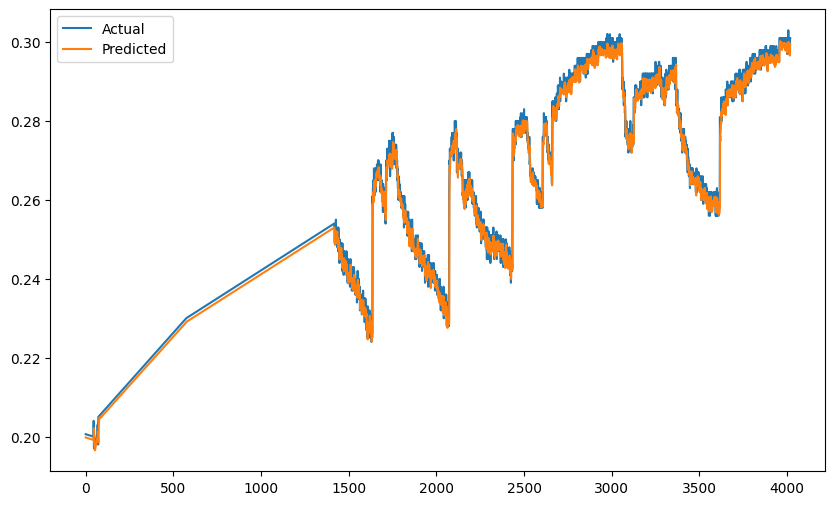

In [114]:
# Test the model and print the curves
model = tf.keras.models.load_model(f'Best_RNN_Stacked_{column_name}.keras')
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

## Backtesting

In [115]:
# Computing the predictions for different backtesting windows
backtesting_windows = [5, 10, 20]
y_preds = {}
model = tf.keras.models.load_model(f'Best_RNN_Stacked_{column_name}.keras')
for backtesting_window in backtesting_windows:
	print("==========================================")
	print(f"Backtesting window = {backtesting_window}")
	print("==========================================")
	y_preds[backtesting_window] = []
	for i in tqdm(range(0, len(X_test), backtesting_window)):
		lags = np.array(X_test[i])
		for _ in range(backtesting_window):
			new_value = model.predict(np.expand_dims(lags, 0), verbose=0)
			y_preds[backtesting_window].append(new_value)
			lags = np.concatenate((lags[1:], new_value))

Backtesting window = 5


100%|██████████| 804/804 [03:15<00:00,  4.12it/s]


Backtesting window = 10


100%|██████████| 402/402 [03:14<00:00,  2.06it/s]


Backtesting window = 20


100%|██████████| 201/201 [03:19<00:00,  1.01it/s]


btw = 5, mse = 1.1960508386641384e-05
btw = 10, mse = 2.99703903155166e-05
btw = 20, mse = 9.60227942523987e-05
avg = 4.598456431818556e-05


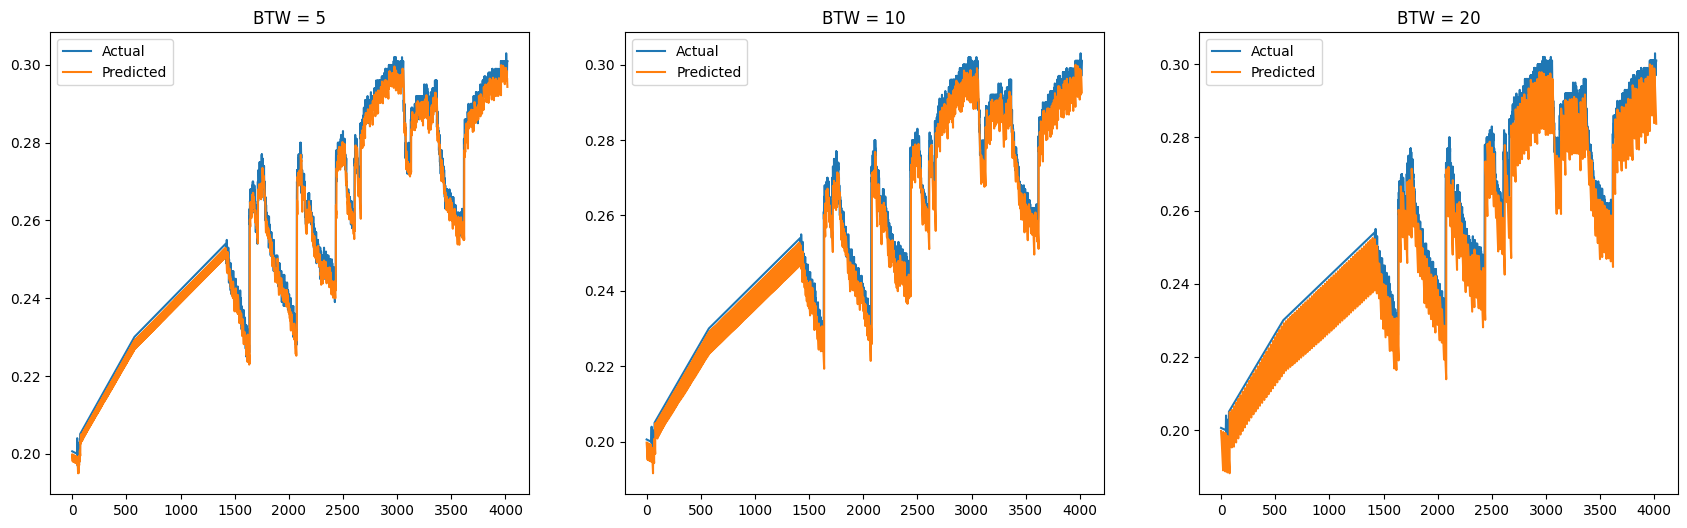

In [116]:
# Computing the errors and plotting the graphs
avg = 0
fig, axs = plt.subplots(1, 3, figsize=(21,6))
for i, (btw, y_pred) in enumerate(y_preds.items()):
	y_pred_rescaled = scaler.inverse_transform(np.array(y_pred)[:,:,0][:len(y_test)])
	y_test_rescaled = scaler.inverse_transform(y_test)
	axs[i].plot(y_test_rescaled, label = 'Actual')
	axs[i].plot(y_pred_rescaled, label = 'Predicted')
	axs[i].set_title(f"BTW = {btw}")
	axs[i].legend()
	mse = mean_squared_error(y_pred_rescaled, y_test_rescaled)
	avg += mse
	print(f"btw = {btw}, mse = {mse}")
print(f"avg = {avg/3}")
plt.show()

# CNN + RNN

In [ ]:
# Load the data
file_path = 'DATASET_4_ans.csv'
data = pd.read_csv(file_path)
data.head()

,Year,Month,Day,Hour,Minute,TAir,Precip1,SM_5cm,ST_5cm,SM_10cm,ST_10cm,SM_20cm,ST_20cm,SM_50cm,ST_50cm
0,2014.0,5.0,30.0,12.0,0.0,16.6,0.0,0.188,19.1,0.148,18.8,0.123,18.0,0.165,17.3
1,2014.0,5.0,30.0,13.0,0.0,17.7,0.0,0.187,19.7,0.150,19.5,0.122,18.0,0.164,17.3
2,2014.0,5.0,30.0,14.0,0.0,18.9,0.0,0.187,20.7,0.150,20.3,0.126,18.4,0.165,17.3
3,2014.0,5.0,30.0,15.0,0.0,19.5,0.0,0.186,20.7,0.158,21.1,0.120,18.6,0.167,17.3
4,2014.0,5.0,30.0,16.0,0.0,20.1,0.0,0.183,20.7,0.161,21.1,0.125,19.1,0.167,17.3


In [118]:
data = data[['Year', 'Month', 'Day', 'Hour', 'Minute', column_name]]
data.dropna(axis=0, inplace=True)
# Convert time columns to a datetime index
data['Datetime'] = pd.to_datetime({
    'year': data['Year'].astype(int),
    'month': data['Month'].astype(int),
    'day': data['Day'].astype(int),
    'hour': data['Hour'].astype(int),
    'minute': data['Minute'].astype(int)
})
data.set_index('Datetime', inplace=True)
data = data[[column_name]]
data = data.resample('h').interpolate()

In [119]:
# # Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

In [120]:
# Create sequences for time series modeling
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 24  # e.g., use the past 24 time steps (1 day if hourly data) to predict the next
X, y = create_sequences(data_scaled, sequence_length)

In [121]:
# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)

## Baseline

In [122]:
# Build the RNN model (LSTM example)
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=10, kernel_size=3, activation='relu', padding='valid'),
    tf.keras.layers.SimpleRNN(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
# Compile the model
model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_42 (SimpleRNN)       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [123]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(f'Baseline_CNN_RNN_{column_name}.keras', save_best_only=True, monitor='val_loss', mode='min', verbose=1)

In [ ]:
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[checkpoint])

Epoch 1/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0025
Epoch 1: val_loss improved from inf to 0.00019, saving model to Baseline_CNN_RNN_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0025 - val_loss: 1.9377e-04
Epoch 2/20
1130/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.8058e-04
Epoch 2: val_loss improved from 0.00019 to 0.00019, saving model to Baseline_CNN_RNN_ SM_50cm.keras
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.8050e-04 - val_loss: 1.8753e-04
Epoch 3/20
1129/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 5.0373e-04
Epoch 3: val_loss did not improve from 0.00019
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 5.0349e-04 - val_loss: 1.9882e-04
Epoch 4/20
1128/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 3.8707e-04
Epoch 4: val_loss did not improve from 0.00019
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 3.8713e-04 - val_loss: 1.9288e-04
Epoch 5/20
1128/1131 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.2700e-04
Epoch 5: val_

In [125]:
model.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 22, 10)         │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_42 (SimpleRNN)       │ (None, 64)             │         4,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,717 (57.49 KB)

 Trainable params: 4,905 (19.16 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 9,812 (38.33 KB)

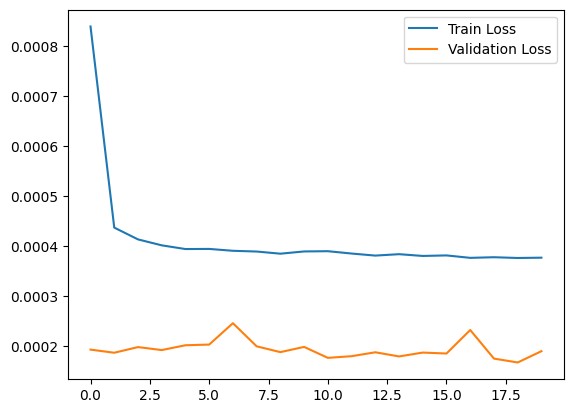

In [126]:
# Plot training history
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

In [127]:
model = tf.keras.models.load_model(f'Baseline_CNN_RNN_{column_name}.keras')

In [128]:
# Make predictions
y_pred = model.predict(X_test)

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


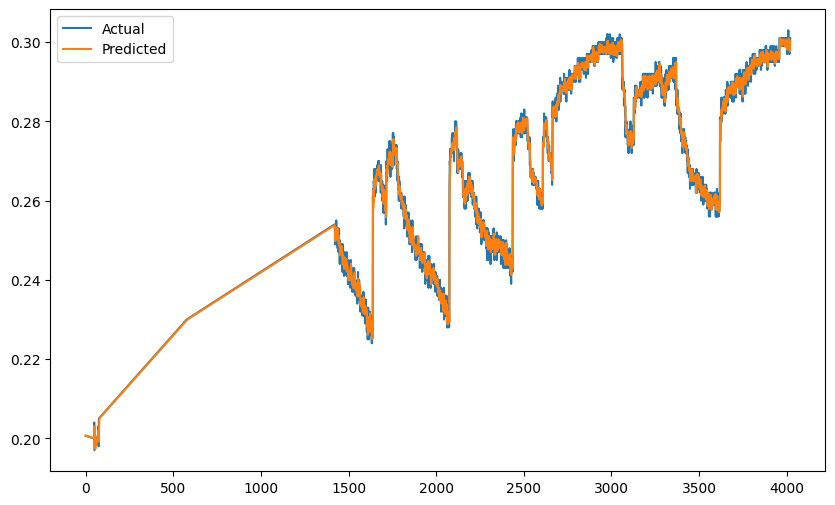

In [129]:
# Rescale predictions back to the original scale
y_test_rescaled = scaler.inverse_transform(y_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)

# Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

In [130]:
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 4.038366297772994e-06


## Parameter-Tuning

In [131]:
# tune the sequence length and the number of neurons in the RNN layer
sequence_lengths = [24]
kernel_sizes = [3, 6]
filters = [10, 20]
neurons = [64, 128]

best_mse = float('inf')

for sequence_length in sequence_lengths:
	X, y = create_sequences(data_scaled, sequence_length)
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
	X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, shuffle=False)
	for kernel_size in kernel_sizes:
		for filter in filters:
			for neuron in neurons:
				model = tf.keras.Sequential([
					tf.keras.layers.Conv1D(filters=filter, kernel_size=kernel_size, activation='relu', padding='valid'),
					tf.keras.layers.SimpleRNN(neuron, activation='relu'),
					tf.keras.layers.Dense(1)
				])
				model.compile(optimizer='adam', loss='mse')
				print(f'==================================================================================================')
				print(f'Training model with : sequence length = {sequence_length} and kernel_size = {kernel_size} and filter = {filter} and neuron = {neuron}')
				print(f'==================================================================================================')
				history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
				y_pred = model.predict(X_val)
				y_val_rescaled = scaler.inverse_transform(y_val)
				y_pred_rescaled = scaler.inverse_transform(y_pred)
				mse = mean_squared_error(y_val_rescaled, y_pred_rescaled)
				if mse < best_mse:
					best_mse = mse
					best_sequence_length = sequence_length
					best_kernel_size = kernel_size
					best_filter = filter
					best_neuron = neuron
					print(f'New best MSE: {best_mse} with sequence length = {best_sequence_length} and kernel_size = {best_kernel_size} and filter = {best_filter} and neuron = {best_neuron}')

print(f'==================================================================================================')
print(f'==================================================================================================')
print(f'Best MSE: {best_mse} with sequence length = {best_sequence_length} and kernel_size = {best_kernel_size} and filter = {best_filter} and neuron = {best_neuron}')

Training model with : sequence length = 24 and kernel_size = 3 and filter = 10 and neuron = 64
Epoch 1/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0145 - val_loss: 3.4050e-04
Epoch 2/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 5.5034e-04 - val_loss: 3.3542e-04
Epoch 3/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.2644e-04 - val_loss: 3.7891e-04
Epoch 4/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9109e-04 - val_loss: 3.2925e-04
Epoch 5/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.0164e-04 - val_loss: 3.1299e-04
Epoch 6/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9571e-04 - val_loss: 3.9938e-04
Epoch 7/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.6385e-04 - val_loss: 2.7961e-04
Epoch 8/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.2009e-04 - val_loss: 2.8877e-04
Epoch 9/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.3004e-04 - val_loss: 2.7323e-04
Epoch 10/20
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 3s

In [132]:
# Retrain the model using the best parameters on the whole train data and save it
X, y = create_sequences(data_scaled, best_sequence_length)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, shuffle=False)
model = tf.keras.Sequential([
	tf.keras.layers.Conv1D(filters=best_filter, kernel_size=best_kernel_size, activation='relu', padding='valid'),
	tf.keras.layers.SimpleRNN(best_neuron, activation='relu'),
	tf.keras.layers.Dense(1)
	])
model.compile(optimizer='adam', loss='mse')
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val), verbose=1)
model.save(f"Best_CNN_RNN_{column_name}.keras")

Epoch 1/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0044 - val_loss: 4.2059e-04
Epoch 2/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.8476e-04 - val_loss: 3.3057e-04
Epoch 3/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.9393e-04 - val_loss: 2.9547e-04
Epoch 4/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4319e-04 - val_loss: 3.6021e-04
Epoch 5/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.8763e-04 - val_loss: 3.2018e-04
Epoch 6/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 4.5526e-04 - val_loss: 2.7509e-04
Epoch 7/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 3.5713e-04 - val_loss: 2.8202e-04
Epoch 8/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.4589e-04 - val_loss: 4.8247e-04
Epoch 9/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.1216e-04 - val_loss: 3.5567e-04
Epoch 10/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 4.5737e-04 - val_loss: 2.8480e-04
Epoch 11/20
1131/1131 ━━━━━━━━━━━━━━━━━━━━ 

126/126 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Mean Squared Error: 4.11656147954143e-06


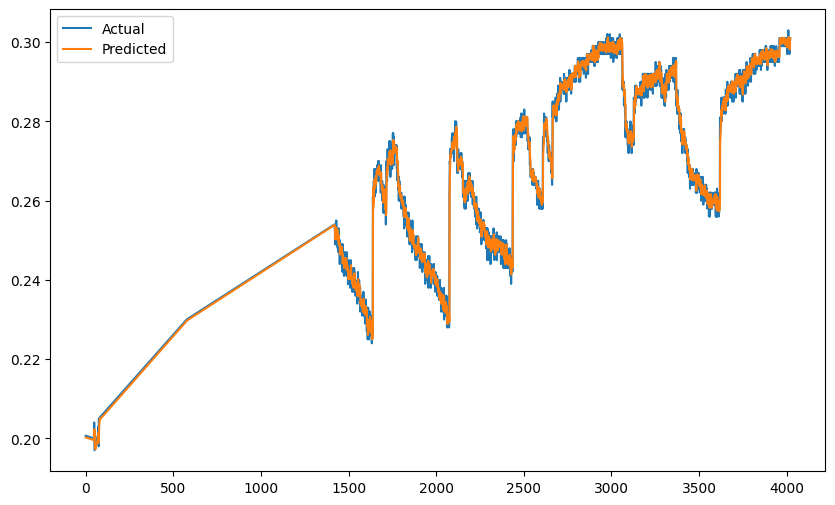

In [133]:
# Test the model and print the curves
model = tf.keras.models.load_model(f'Best_CNN_RNN_{column_name}.keras')
y_pred = model.predict(X_test)
y_pred_rescaled = scaler.inverse_transform(y_pred)
y_test_rescaled = scaler.inverse_transform(y_test)
mse = mean_squared_error(y_test_rescaled, y_pred_rescaled)
print(f'Mean Squared Error: {mse}')
plt.figure(figsize=(10, 6))
plt.plot(y_test_rescaled, label='Actual')
plt.plot(y_pred_rescaled, label='Predicted')
plt.legend()
plt.show()

## Backtesting

In [134]:
# Computing the predictions for different backtesting windows
backtesting_windows = [5, 10, 20]
y_preds = {}
model = tf.keras.models.load_model(f'Best_CNN_RNN_{column_name}.keras')
for backtesting_window in backtesting_windows:
	print("==========================================")
	print(f"Backtesting window = {backtesting_window}")
	print("==========================================")
	y_preds[backtesting_window] = []
	for i in tqdm(range(0, len(X_test), backtesting_window)):
		lags = np.array(X_test[i])
		for _ in range(backtesting_window):
			new_value = model.predict(np.expand_dims(lags, 0), verbose=0)
			y_preds[backtesting_window].append(new_value)
			lags = np.concatenate((lags[1:], new_value))

Backtesting window = 5


100%|██████████| 805/805 [03:13<00:00,  4.16it/s]


Backtesting window = 10


100%|██████████| 403/403 [03:20<00:00,  2.01it/s]


Backtesting window = 20


100%|██████████| 202/202 [03:19<00:00,  1.01it/s]


btw = 5, mse = 7.1166182510290795e-06
btw = 10, mse = 9.186198612379012e-06
btw = 20, mse = 1.4609220603211082e-05
avg = 1.0304012488873058e-05


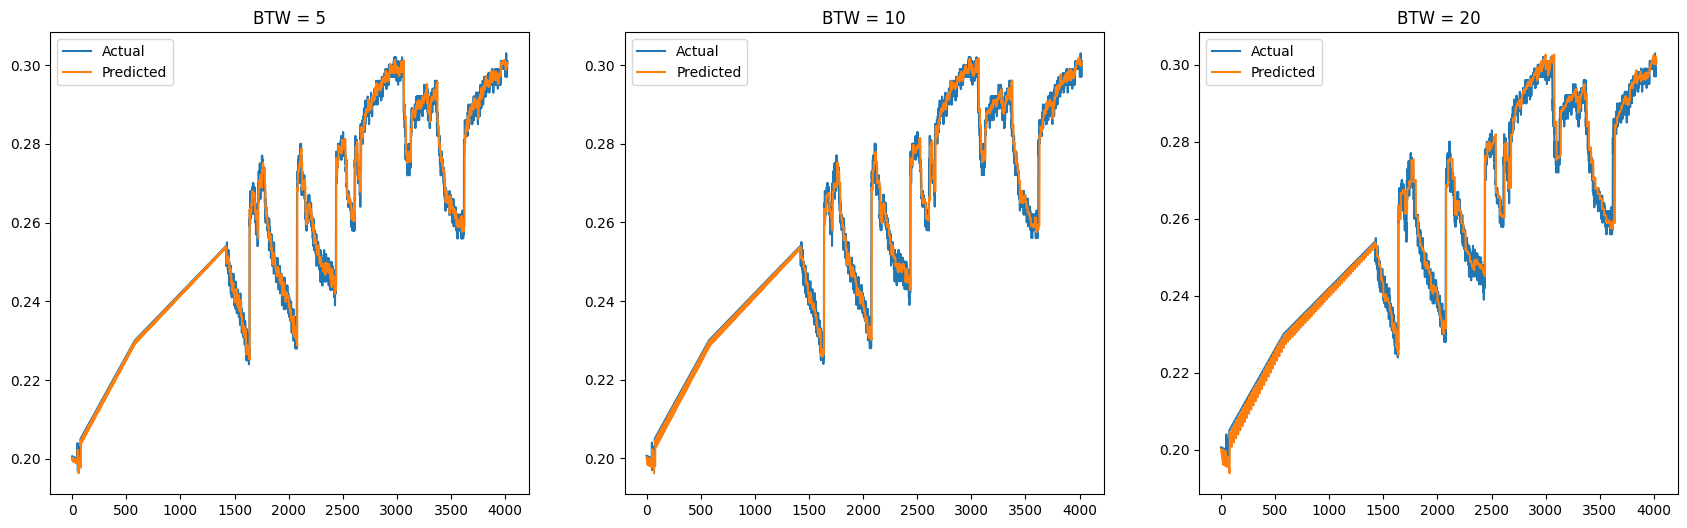

In [135]:
# Computing the errors and plotting the graphs
avg = 0
fig, axs = plt.subplots(1, 3, figsize=(21,6))
for i, (btw, y_pred) in enumerate(y_preds.items()):
	y_pred_rescaled = scaler.inverse_transform(np.array(y_pred)[:,:,0][:len(y_test)])
	y_test_rescaled = scaler.inverse_transform(y_test)
	axs[i].plot(y_test_rescaled, label = 'Actual')
	axs[i].plot(y_pred_rescaled, label = 'Predicted')
	axs[i].set_title(f"BTW = {btw}")
	axs[i].legend()
	mse = mean_squared_error(y_pred_rescaled, y_test_rescaled)
	avg += mse
	print(f"btw = {btw}, mse = {mse}")
print(f"avg = {avg/3}")
plt.show()